# Analysis and Synthesis of Spring Reverb

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

In [5]:
cmap = plt.get_cmap('inferno')
num_colors = 20
colors = cmap(np.linspace(0, 1, num_colors))

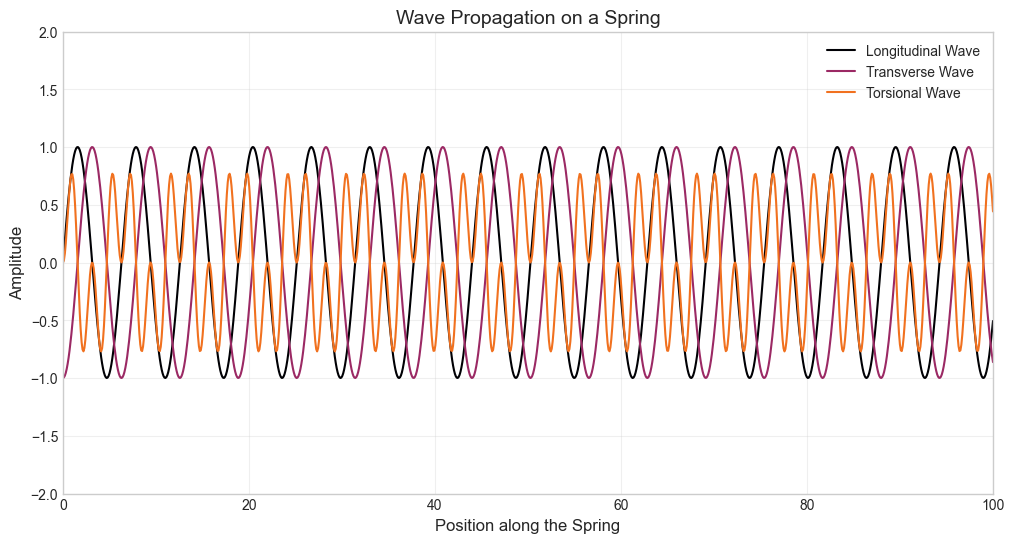

In [6]:
# Functions to generate wave data
def generate_longitudinal_wave():
    x = np.linspace(0, 100, 1000)
    y = np.sin(x)
    return x, y

def generate_transverse_wave():
    x = np.linspace(0, 100, 1000)
    y = np.sin(x - np.pi / 2)
    return x, y

def generate_torsional_wave():
    x = np.linspace(0, 100, 1000)
    y = np.sin(x) * np.sin(2 * x)
    return x, y

# Plotting all three waves in a single figure
plt.figure(figsize=(12, 6))

# Longitudinal wave
x, y = generate_longitudinal_wave()
plt.plot(x, y, label="Longitudinal Wave", color=colors[0], linewidth=1.5)

# Transverse wave
x, y = generate_transverse_wave()
plt.plot(x, y, label="Transverse Wave", color=colors[8], linewidth=1.5)

# Torsional wave
x, y = generate_torsional_wave()
plt.plot(x, y, label="Torsional Wave", color=colors[13], linewidth=1.5)

# General plot settings
plt.title("Wave Propagation on a Spring", fontsize=14)
plt.xlabel("Position along the Spring", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.xlim(0, 100)
plt.ylim(-2, 2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The following is inspired by a tutorial by Dan Pierce on the analysis and synthesis of spring reverb. The tutorial can be found [here](https://youtu.be/q63ypxds0cY?si=UZvkxzq3RLu31IqF).

IR sample rate: 48000


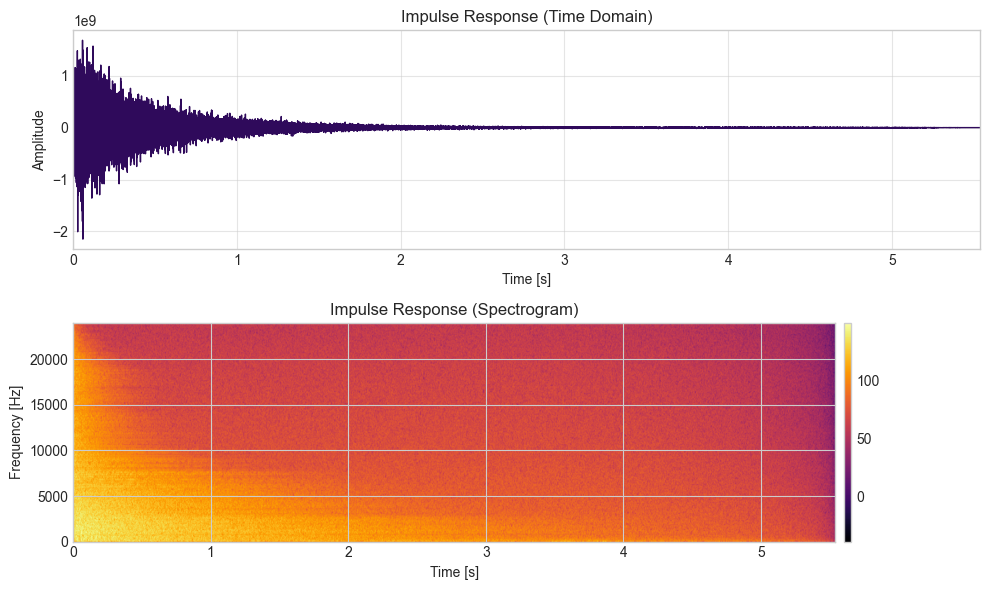

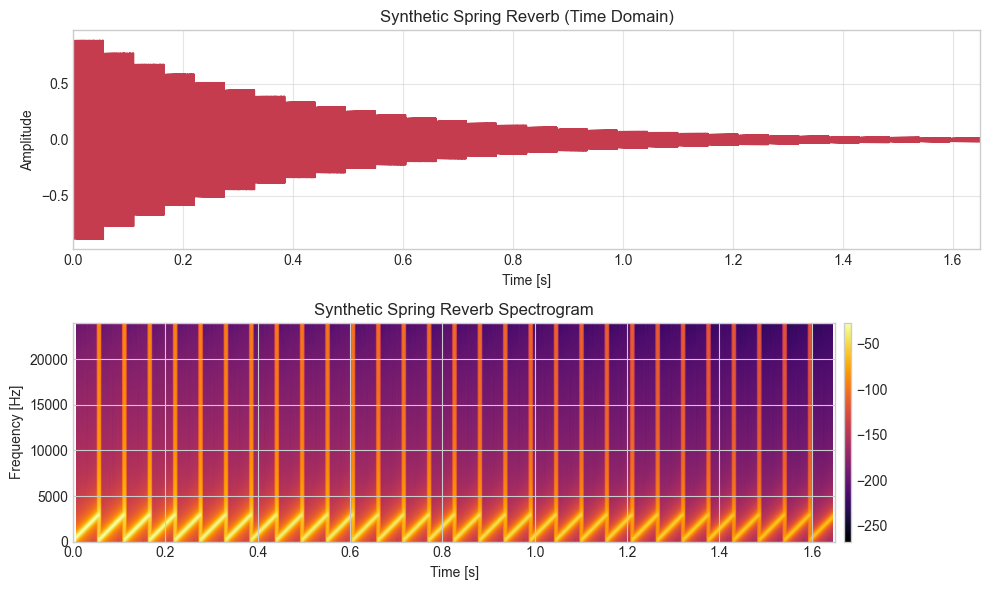

In [7]:
db_to_mag = lambda x: 10 ** (x / 20)
mag_to_db = lambda x: 20 * np.log10(x)

input_file: str = "../audio/plk-fm-base.wav"
output_file: str = "../audio/output_convolve.wav"
ir_file: str = "../audio/IR_AKG_BX25_3500ms_dark_48kHz24b.wav"
conv_method: str = "direct"

wet_mix: float = 0.5

sr, ir_sig = wavfile.read(ir_file)
print(f"IR sample rate: {sr}")
ir_sig = ir_sig[ir_sig != 0]
# ir_sig /= np.max(np.abs(ir_sig))

input_sr, input_sig = wavfile.read(input_file)

assert sr == input_sr, "Sample rates must match"

wet_sig = signal.fftconvolve(input_sig, ir_sig)
wet_sig /= np.max(np.abs(wet_sig))

dry_sig = np.concatenate((input_sig, np.zeros(len(wet_sig) - len(input_sig))))
output_sig = dry_sig + db_to_mag(-3) * wet_sig
output_sig /= np.max(np.abs(output_sig))

wavfile.write("../audio/wet.wav", sr, wet_sig)
wavfile.write("../audio/mix.wav", sr, output_sig)

time_array = np.arange(len(ir_sig)) / sr

# Constants
cmap = plt.get_cmap('inferno')

ECHO_PERIOD = 55e-3
SWEEP_START_FREQ_HZ = 200
SWEEP_END_FREQ_HZ = 3000
NUM_ECHOES = 30

echo_period_samples = round(ECHO_PERIOD * sr)

len_ir_samples = echo_period_samples * NUM_ECHOES
synthetic_spring_ir = np.zeros(len_ir_samples)

sweep_freq_env = np.linspace(
    SWEEP_START_FREQ_HZ, SWEEP_END_FREQ_HZ, echo_period_samples
    )

sweep_sig = np.sin(2 * np.pi *  np.cumsum(sweep_freq_env) / sr)

echo_amp = db_to_mag(-1)

for echo_index in np.arange(NUM_ECHOES) * echo_period_samples:
    sweep_index_array = echo_index + np.arange(len(sweep_sig))
    synthetic_spring_ir[sweep_index_array] = (
        synthetic_spring_ir[sweep_index_array] + echo_amp * sweep_sig
        )
    echo_amp *= db_to_mag(-1.2)

# Plot 2: Synthetic Spring Reverb Impulse Response
time_array_spring = np.linspace(0, len(synthetic_spring_ir) / sr, len(synthetic_spring_ir))


# Plot 1: Impulse Response (Time Domain) and Spectrogram
time_array = np.arange(len(ir_sig)) / sr

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)  # Align x-axis using sharex=True

# Plot impulse response in the time domain
axs[0].plot(time_array, ir_sig, color=colors[3], linewidth=1)
axs[0].grid(alpha=0.5)
axs[0].set_title("Impulse Response (Time Domain)", fontsize=12)
axs[0].set_xlabel("Time [s]", fontsize=10)  
axs[0].set_ylabel("Amplitude", fontsize=10)
axs[0].tick_params(axis="x", labelbottom=True)  # Enable x-axis ticks for the top plot

# Plot impulse response spectrogram
cax = axs[1].specgram(ir_sig, Fs=sr, NFFT=512, noverlap=500, cmap=cmap, scale_by_freq=True)
fig.colorbar(cax[3], ax=axs[1], pad=0.01, aspect=30)  # Add color bar
axs[1].set_title("Impulse Response (Spectrogram)", fontsize=12)
axs[1].set_xlabel("Time [s]", fontsize=10)
axs[1].set_ylabel("Frequency [Hz]", fontsize=10)

# Set consistent x-axis limits
axs[0].set_xlim([time_array[0], time_array[-1]])
axs[1].set_xlim([time_array[0], time_array[-1]])

plt.tight_layout()
plt.show()

# Plot 2: Synthetic Spring Reverb Impulse Response and Spectrogram
time_array_spring = np.linspace(0, len(synthetic_spring_ir) / sr, len(synthetic_spring_ir))

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot spring reverb impulse response
axs[0].plot(time_array_spring, synthetic_spring_ir, color=colors[10], linewidth=1)
axs[0].grid(alpha=0.5)
axs[0].set_title("Synthetic Spring Reverb (Time Domain)", fontsize=12)
axs[0].set_xlabel("Time [s]", fontsize=10)
axs[0].set_ylabel("Amplitude", fontsize=10)
axs[0].tick_params(axis="x", labelbottom=True)  # Enable x-axis ticks for the top plot

# Plot spring reverb spectrogram
cax = axs[1].specgram(synthetic_spring_ir, Fs=sr, NFFT=512, noverlap=500, cmap=cmap, scale_by_freq=True)
fig.colorbar(cax[3], ax=axs[1], pad=0.01, aspect=30)
axs[1].set_title("Synthetic Spring Reverb Spectrogram", fontsize=12)
axs[1].set_xlabel("Time [s]", fontsize=10)
axs[1].set_ylabel("Frequency [Hz]", fontsize=10)

# Set consistent x-axis limits
axs[0].set_xlim([time_array_spring[0], time_array_spring[-1]])
axs[1].set_xlim([time_array_spring[0], time_array_spring[-1]])

plt.tight_layout()
plt.show()

wet_sig = signal.fftconvolve(input_sig, synthetic_spring_ir)
wet_sig = wet_sig * db_to_mag(-32)
dry_sig = np.concatenate((input_sig, np.zeros(len(wet_sig) - len(input_sig)))
)
output_sig = dry_sig + db_to_mag(-24) * wet_sig

wavfile.write("../audio/synthetic_spring_reverb.wav", sr, output_sig.astype(np.int32))

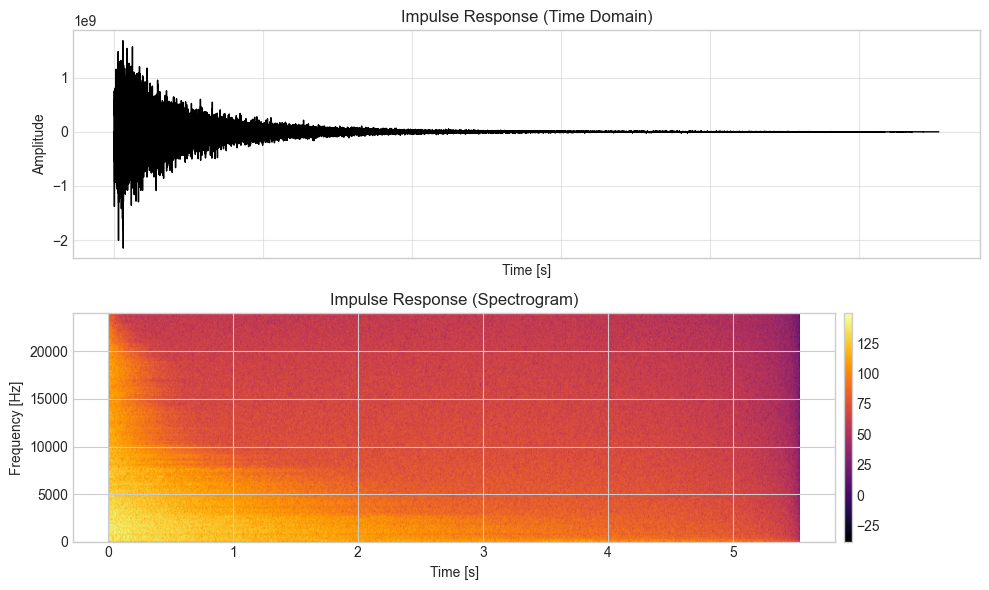

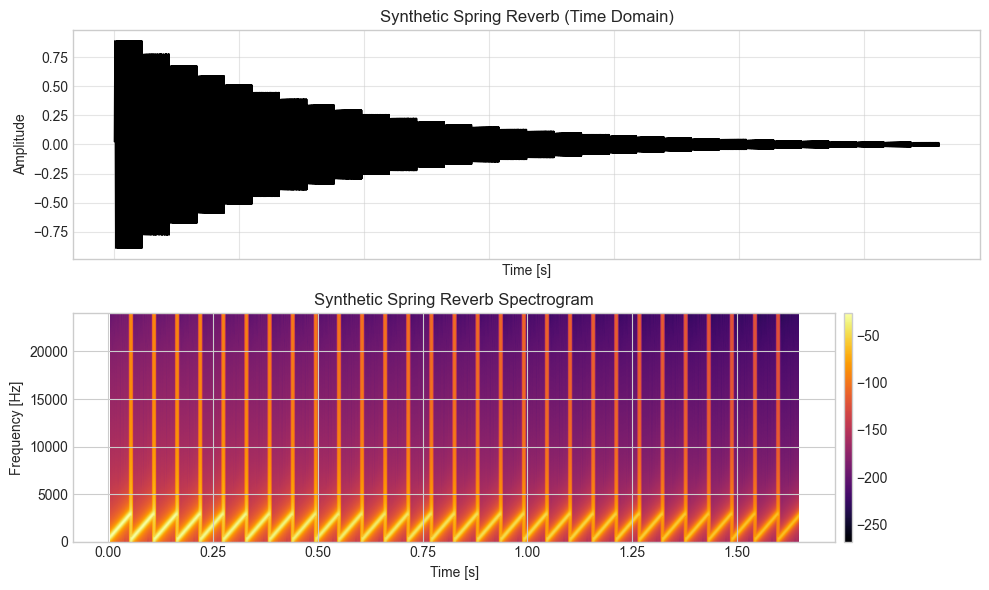

[]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wavfile

# Define helper functions
db_to_mag = lambda x: 10 ** (x / 20)
mag_to_db = lambda x: 20 * np.log10(x)

# Constants
SPEED_OF_SOUND = 343  # Speed of sound in air (m/s)
ECHO_PERIOD = 55e-3
SWEEP_START_FREQ_HZ = 200
SWEEP_END_FREQ_HZ = 3000
NUM_ECHOES = 30

# File paths
input_file = "../audio/plk-fm-base.wav"
output_file = "../audio/output_convolve.wav"
ir_file = "../audio/IR_AKG_BX25_3500ms_dark_48kHz24b.wav"

# Read impulse response file
sr, ir_sig = wavfile.read(ir_file)
if ir_sig.ndim > 1:
    ir_sig = ir_sig[:, 0]  # Convert to mono if needed

ir_sig = ir_sig[ir_sig != 0]  # Remove leading/trailing zeros

# Read input audio file
input_sr, input_sig = wavfile.read(input_file)
if input_sig.ndim > 1:
    input_sig = input_sig[:, 0]  # Convert to mono if needed

# Ensure matching sample rates
assert sr == input_sr, "Sample rates must match"

# Convolution with impulse response
wet_sig = signal.fftconvolve(input_sig, ir_sig, mode="full")
wet_sig /= np.max(np.abs(wet_sig))  # Normalize

# Mix dry and wet signal
dry_sig = np.pad(input_sig, (0, len(wet_sig) - len(input_sig)), mode='constant')
output_sig = dry_sig + db_to_mag(-3) * wet_sig
output_sig /= np.max(np.abs(output_sig))

# Save output files
wavfile.write("../audio/wet.wav", sr, wet_sig.astype(np.float32))
wavfile.write("../audio/mix.wav", sr, output_sig.astype(np.float32))

# Generate synthetic spring reverb impulse response
echo_period_samples = round(ECHO_PERIOD * sr)
len_ir_samples = echo_period_samples * NUM_ECHOES
synthetic_spring_ir = np.zeros(len_ir_samples)

sweep_freq_env = np.linspace(SWEEP_START_FREQ_HZ, SWEEP_END_FREQ_HZ, echo_period_samples)
sweep_sig = np.sin(2 * np.pi * np.cumsum(sweep_freq_env) / sr)

echo_amp = db_to_mag(-1)

for echo_index in np.arange(NUM_ECHOES) * echo_period_samples:
    sweep_index_array = echo_index + np.arange(len(sweep_sig))
    synthetic_spring_ir[sweep_index_array] += echo_amp * sweep_sig
    echo_amp *= db_to_mag(-1.2)

# Time arrays
time_array_ir = np.arange(len(ir_sig)) / sr
time_array_spring = np.linspace(0, len(synthetic_spring_ir) / sr, len(synthetic_spring_ir))

# Plot impulse response
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot impulse response in time domain
axs[0].plot(time_array_ir, ir_sig, color="black", linewidth=1)
axs[0].grid(alpha=0.5)
axs[0].set_title("Impulse Response (Time Domain)", fontsize=12)
axs[0].set_xlabel("Time [s]", fontsize=10)  
axs[0].set_ylabel("Amplitude", fontsize=10)

# Plot impulse response spectrogram
cax = axs[1].specgram(ir_sig, Fs=sr, NFFT=512, noverlap=500, cmap="inferno", scale_by_freq=True)
fig.colorbar(cax[3], ax=axs[1], pad=0.01, aspect=30)
axs[1].set_title("Impulse Response (Spectrogram)", fontsize=12)
axs[1].set_xlabel("Time [s]", fontsize=10)
axs[1].set_ylabel("Frequency [Hz]", fontsize=10)

plt.tight_layout()
plt.show()

# Plot synthetic spring reverb impulse response
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(time_array_spring, synthetic_spring_ir, color="black", linewidth=1)
axs[0].grid(alpha=0.5)
axs[0].set_title("Synthetic Spring Reverb (Time Domain)", fontsize=12)
axs[0].set_xlabel("Time [s]", fontsize=10)
axs[0].set_ylabel("Amplitude", fontsize=10)

cax = axs[1].specgram(synthetic_spring_ir, Fs=sr, NFFT=512, noverlap=500, cmap="inferno", scale_by_freq=True)
fig.colorbar(cax[3], ax=axs[1], pad=0.01, aspect=30)
axs[1].set_title("Synthetic Spring Reverb Spectrogram", fontsize=12)
axs[1].set_xlabel("Time [s]", fontsize=10)
axs[1].set_ylabel("Frequency [Hz]", fontsize=10)

plt.tight_layout()
plt.show()

# Apply synthetic spring reverb
wet_sig_spring = signal.fftconvolve(input_sig, synthetic_spring_ir, mode="full")
wet_sig_spring *= db_to_mag(-32)

dry_sig = np.pad(input_sig, (0, len(wet_sig_spring) - len(input_sig)), mode='constant')
output_sig_spring = dry_sig + db_to_mag(-24) * wet_sig_spring

# Save processed audio
wavfile.write("../audio/synthetic_spring_reverb.wav", sr, output_sig_spring.astype(np.int32))

# Check for errors and repetitions
errors = []
if len(ir_sig) == 0:
    errors.append("Impulse response file is empty or incorrectly processed.")
if len(input_sig) == 0:
    errors.append("Input file is empty or incorrectly processed.")
if sr != input_sr:
    errors.append("Sample rates do not match.")
if len(wet_sig) == 0 or len(wet_sig_spring) == 0:
    errors.append("Wet signal processing failed.")

errors

